# Modeling and Finding Trends

The purpose of this notebook is to use natural language processing on the Jose Mourinho youtube captions. I will use word counts and dimension reduction to topic model. Once topics are found, I will search for interesting trends throughout his career.

In [1]:
import pickle
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
plt.style.use('bmh')
from gensim import corpora, models, similarities, matutils
%matplotlib inline
from datetime import datetime
import copy
from itertools import chain
import matplotlib.image as mpimg 

In [2]:
with open('Data/spurs.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
df = df.drop(['Language'],axis='columns')

In [4]:
df['Sentiment Polarity']=df['Caption'].apply(lambda x:TextBlob(x).sentiment[0])
df['Sentiment Subjectivity']=df['Caption'].apply(lambda x:TextBlob(x).sentiment[1])

In [5]:
df['Published Datetime'] =pd.to_datetime(df['Published Datetime'])


Record sentiment of each video 

In [6]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

#scoress = sid.polarity_scores('hi my name is adam and i am happy')
#scoress.get('compound')
df['Sentiment Vader']=df['Caption'].apply(lambda x:sid.polarity_scores(x).get("compound"))

/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Plot sentiment over time

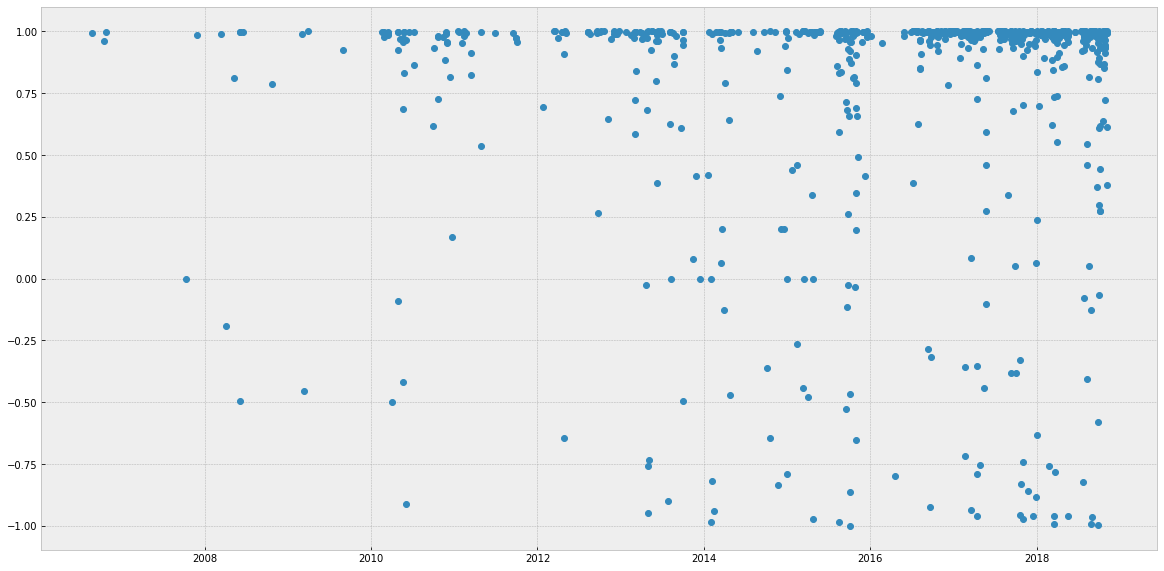

In [7]:
plt.figure(figsize=(20,10))
plt.plot_date(df['Published Datetime'],df['Sentiment Vader'])

## Tokenizer

Process text formatting and remove stop words

In [8]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def custom_tokenizer(text):

    # remove punctuation
    remove_punct = str.maketrans('', '', string.punctuation)
    text = text.translate(remove_punct)

    # remove digits and convert to lower case
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)

    # tokenize
    tokens = word_tokenize(text)

    # remove stop words
    stop_words = stopwords.words('english')
    stop_words_sp = stopwords.words('spanish')
    more_stops=['get','yeah','hes','still','got','gon','na','cause','tickets','ticket',
                'prices','price','buy','buying','de','knew', 'always','another','bt','channel',
               'theres','ive','cant','maybe','your','youre','okay','ask','weve','said',
                'tomorrow','says','mourinho','jose','already','youve','cristiano','ronaldo','opponents'
               ,'madrid','liverpool','smelling','real','stamford','bridge','paul','pogba',
               'tottenham','marwan','since','year','city','happening','giving','piace','july','conference'
               ,'assad','barcelona','coach','note','date','seven','investments','wouldnt','fa',
               'monday','tuesday','saturday','sunday','wednesday','valencia','fourth','twice',
               'antonio','mateo','sevilla','kids','josie','israel','hi','eight','spain',
                'havent','th','michael','person','hours','arsenal','mine','portugal','portuguese'
               ,'spanish','latin','inter','must','games','stay','name','photo','juventus',
               'according','known','form','boy','porto','party','house','found']
    stop_words=stop_words+more_stops+stop_words_sp
    tokens_stop = [y for y in tokens if y not in stop_words]

    # stem
    #stemmer = SnowballStemmer('english')
    #tokens_stem = [stemmer.stem(y) for y in tokens_stop] 

    return tokens_stop

## LDA

First attempt: Use LDA model to find topics 

In [9]:
cv = CountVectorizer(tokenizer=custom_tokenizer,max_df=0.1, min_df=35)
word_freq_count =  cv.fit_transform(df['Caption'])

In [10]:
corpus = matutils.Sparse2Corpus(word_freq_count.transpose())

In [11]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())
id2word = corpora.Dictionary.from_corpus(corpus, 
                                         id2word=id2word)

In [12]:
lda = models.LdaModel(corpus=corpus, num_topics=8, id2word=id2word, passes=10)

In [13]:
words=cv.get_feature_names()
doc_mat = lda.get_topics()
filename = 'Data/word_dist.pkl'
pickle.dump(word_freq_count, open(filename, 'wb'))

filename2 = 'Data/word_model.pkl'
pickle.dump(words, open(filename2, 'wb'))

filename3 = 'Data/word_params.pkl'
pickle.dump(doc_mat, open(filename3, 'wb'))

In [14]:
lda.print_topics(8,10)

[(0,
  '0.010*"direct" + 0.009*"newcastle" + 0.009*"performances" + 0.008*"goalkeeper" + 0.008*"space" + 0.008*"similar" + 0.007*"solid" + 0.007*"scoring" + 0.007*"organized" + 0.007*"outside"'),
 (1,
  '0.024*"penalty" + 0.015*"disappointed" + 0.013*"spirit" + 0.013*"desire" + 0.010*"solid" + 0.009*"lukaku" + 0.009*"impossible" + 0.009*"nil" + 0.009*"penalties" + 0.008*"showed"'),
 (2,
  '0.036*"compare" + 0.017*"step" + 0.016*"calm" + 0.010*"market" + 0.010*"positions" + 0.010*"approach" + 0.009*"visit" + 0.008*"leagues" + 0.008*"aggressive" + 0.007*"balance"'),
 (3,
  '0.013*"finished" + 0.011*"card" + 0.010*"responsibility" + 0.010*"men" + 0.009*"nine" + 0.009*"least" + 0.009*"red" + 0.009*"confident" + 0.008*"inside" + 0.008*"negative"'),
 (4,
  '0.011*"captain" + 0.010*"joe" + 0.009*"kid" + 0.009*"use" + 0.009*"school" + 0.009*"move" + 0.008*"success" + 0.008*"law" + 0.007*"board" + 0.007*"process"'),
 (5,
  '0.015*"penalty" + 0.014*"passion" + 0.014*"referee" + 0.013*"afraid" + 

## NMF

Second attempt: Use NMF to find topics

In [15]:
from sklearn.decomposition import NMF

In [16]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

"Cross validation":

In [21]:
for i in range(3,11):
    tfidf = TfidfVectorizer(tokenizer=custom_tokenizer,max_df=0.1, min_df=35)
    word_freq =  tfidf.fit_transform(df['Caption'])
    model = NMF(n_components=i)
    doc_topics = model.fit_transform(word_freq)
    tfidf_feature_names = tfidf.get_feature_names()
    print_top_words(model, tfidf_feature_names, 10)
    topid=[]
    for doc in doc_topics:
        topid.append(np.argmax(doc))
    print("Topics: "+str(i)+" "+str(Counter(topid)))

Topic #0: step contract success enjoy process europe championship injuries read dream
Topic #1: compare calm visit leagues sites popular confused peace spent positions
Topic #2: penalty referee card decisions solid red yellow disappointed referees punished

Topics: 3 Counter({0: 573, 2: 281, 1: 63})
Topic #0: step contract enjoy injuries success market process read competitions europe
Topic #1: compare calm visit leagues sites popular peace confused spent positions
Topic #2: penalty referee card decisions red yellow disappointed referees punished solid
Topic #3: school dream law walk field state solid beautiful fan collective

Topics: 4 Counter({0: 470, 2: 243, 3: 143, 1: 61})
Topic #0: step contract enjoy injuries success market process read competitions europe
Topic #1: compare calm visit leagues sites popular peace confused spent positions
Topic #2: penalty referee card decisions red yellow disappointed referees punished solid
Topic #3: school law walk solid field state media fan ki

Select 8 topics. I chose 8 because it gives a more balanced distribution of topics I find interpretable

In [22]:
from sklearn.decomposition import NMF
tfidf = TfidfVectorizer(tokenizer=custom_tokenizer,max_df=0.1, min_df=35)
word_freq =  tfidf.fit_transform(df['Caption'])
model = NMF(n_components=8)
doc_topics = model.fit_transform(word_freq)
tfidf_feature_names = tfidf.get_feature_names()
print_top_words(model, tfidf_feature_names, 10)
topid=[]
for doc in doc_topics:
    topid.append(np.argmax(doc))
print("Topics: "+str(8)+" "+str(Counter(topid)))

Topic #0: step contract enjoy market competitions success captain championship europe process
Topic #1: compare calm visit leagues sites popular peace confused spent confident
Topic #2: spirit solid central nil defenders positions kill defender defensively wall
Topic #3: school law walk state field media fan hit leaving light
Topic #4: penalty referee card red decisions yellow penalties referees punished comment
Topic #5: disappointed desire individual showed react poor surprise explain defeat least
Topic #6: dream challenge reach else accept beautiful spirit defense truth continue
Topic #7: message worried supporters deserved corner zero stays nil interested dangerous

Topics: 8 Counter({0: 300, 2: 235, 3: 97, 5: 71, 4: 64, 7: 59, 1: 50, 6: 41})


In [23]:
words=tfidf.get_feature_names()
params=model.components_
params

array([[0.04793039, 0.07708712, 0.00524088, ..., 0.08997969, 0.11900282,
        0.04884916],
       [0.02327791, 0.00213774, 0.        , ..., 0.02805138, 0.00304433,
        0.        ],
       [0.05528055, 0.05088776, 0.06532883, ..., 0.02374445, 0.02154161,
        0.04706994],
       ...,
       [0.21466624, 0.        , 0.        , ..., 0.01318589, 0.00086298,
        0.01072318],
       [0.10805779, 0.        , 0.        , ..., 0.00564391, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.13048174, 0.04637959,
        0.2538157 ]])

In [24]:
filename = 'Data/word_dist.pkl'
pickle.dump(word_freq, open(filename, 'wb'))

filename2 = 'Data/word_model.pkl'
pickle.dump(words, open(filename2, 'wb'))

filename3 = 'Data/word_params.pkl'
pickle.dump(params, open(filename3, 'wb'))

### Topic Labels
0 - Generic Soccer + Player Rumors
1 - Zen
2 - Park the Bus
3 - Generic Words
4 - Complain about referee
5 - I'm sad we lost
6 - Beautiful Spirit Defense
7 - Fans/Deserve

## Get Distribution of Topics

Find how much of each topic occurs in all of Jose's press conferences

In [25]:
topid=[]
for doc in doc_topics:
    main_cat = np.argmax(doc)
    #print(max(doc))
    rem_doc = copy.deepcopy(doc) 
    rem_doc[main_cat]=0
    #print(max(rem_doc)*2)
    if (max(doc)<=max(rem_doc)*2):
        cat2 = np.argmax(rem_doc)
        topid.append((main_cat,cat2))
    else:
        topid.append((main_cat,main_cat))

Organized by top 2 topics for each press conference

<BarContainer object of 8 artists>

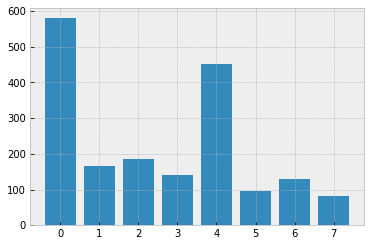

In [26]:
topic_dist=Counter(list(chain(*topid)))
plt.bar(range(len(topic_dist)), list(topic_dist.values()), align='center')

This graph shows all topics for all press conferences

<BarContainer object of 8 artists>

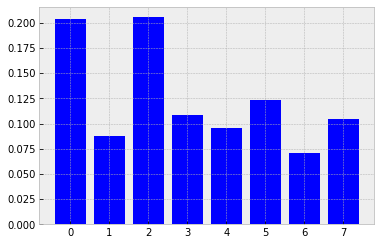

In [27]:
all_tops = [sum(i) for i in zip(*doc_topics)]
plt.bar(range(len(all_tops)), list(all_tops)/sum(list(all_tops)), align='center',color='blue')

## Sentiment Analysis of Each Topic

This shows the sentiment score for each of the 8 topics

In [28]:
tops= ['step contract enjoy market competitions success captain championship europe process',
'compare calm visit leagues sites popular peace confused spent confident',
'spirit solid central nil defenders positions kill defender defensively wall',
'school law walk state field media fan hit leaving light',
'penalty referee card red decisions yellow penalties referees punished comment',
'disappointed desire individual showed react poor surprise explain defeat least',
'dream challenge reach else accept beautiful spirit defense truth continue',
'message worried supporters deserved corner zero stays nil interested dangerous']

In [29]:
tops_sent=[]
for top in tops:
    tops_sent.append(sid.polarity_scores(top).get("compound"))

In [30]:
tops_sent

[0.8689, 0.8591, -0.5106, 0.3182, -0.7184, -0.6597, 0.9081, 0.0772]

## Add topic percents to dataframe

In [31]:
test = pd.DataFrame(doc_topics)

In [32]:
clean_df = df.reset_index()

In [33]:
fin = clean_df.merge(test,left_index=True,right_index=True)

In [34]:
fin['Topic1']=[i[0] for i in topid]
fin['Topic2']=[i[1] for i in topid]

In [35]:
fin['Published Datetime']=fin['Published Datetime'].dt.date
fin['Published Datetime']=pd.to_datetime(fin['Published Datetime'])

## Results

Import Jose team results to compare with topics and sentiment

In [42]:
import pickle
with open('Data/results_df.pkl', 'rb') as f:
    results = pickle.load(f)

In [43]:
results=results.reset_index()

In [44]:
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

In [45]:
fin['Nearest_Result']=fin['Published Datetime'].apply(lambda x: results.loc[results['Date']==nearest(results['Date'],x)].iloc[0]['Num_Result'])

In [46]:
fin = fin.rename(columns={0: 'Generic Soccer and Player Rumors', 1: 'Zen',2: 'Park the Bus'
                         ,3: 'Generic Words',4: 'Complain about the Referee',5: "I'm sad we lost"
                         ,6: 'Beautiful Spirit Defense',7: 'Fans/Deserve'})

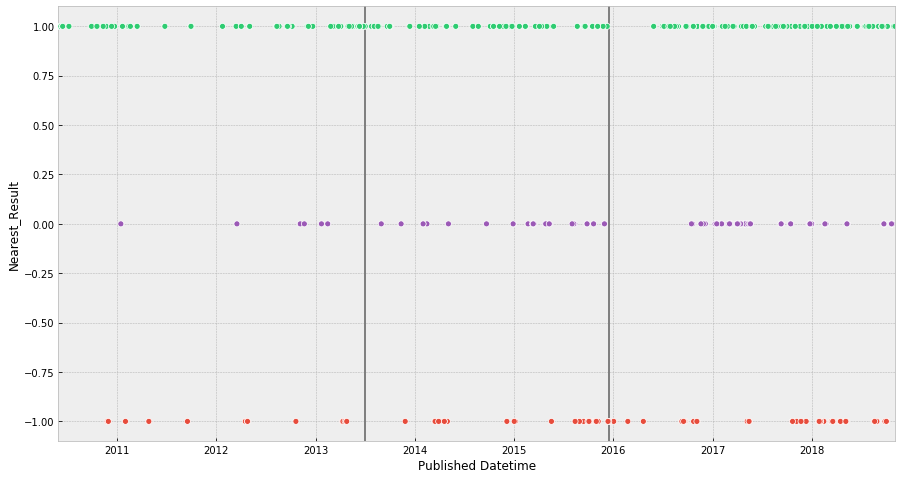

In [47]:
plt.figure(figsize=(15,8))
flatui = ["#e74c3c","#9b59b6","#2ecc71" ]
sns.set_palette(flatui)

#sns.scatterplot(x="Date", y="Num_Result", hue='Mourinho Team', data=results)
lm = sns.scatterplot(x='Published Datetime',y='Nearest_Result',data=fin, hue='Nearest_Result', 
                legend=False,palette=flatui, alpha=1,zorder=3)

a=plt.axvline(x=datetime.strptime('Jun 30 2013', '%b %d %Y'), color='gray', linestyle='-',zorder=2)

b=plt.axvline(x=datetime.strptime('Dec 15 2015', '%b %d %Y'), color='gray', linestyle='-',zorder=2)


lm.set(xlim=(datetime.strptime('May 30 2010', '%b %d %Y'), fin['Published Datetime'].max()));

## Plot Topics Over Time

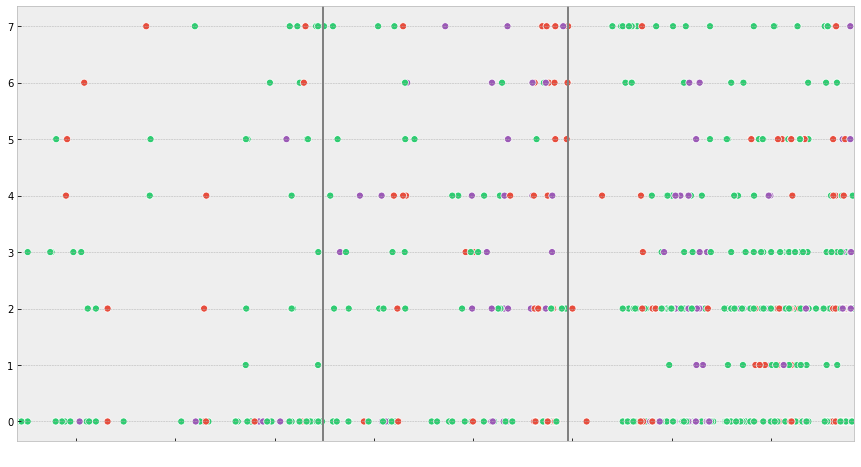

In [48]:
plt.figure(figsize=(15,8))
flatui = ["#e74c3c","#9b59b6","#2ecc71" ]
sns.set_palette(flatui)

#sns.scatterplot(x="Date", y="Num_Result", hue='Mourinho Team', data=results)
lm = sns.scatterplot(x='Published Datetime',y='Topic1',data=fin, hue='Nearest_Result',
                legend=None,palette=flatui, alpha=1,s=50)

plt.axvline(x=datetime.strptime('Jun 30 2013', '%b %d %Y'), color='gray', linestyle='-')

plt.axvline(x=datetime.strptime('Dec 15 2015', '%b %d %Y'), color='gray', linestyle='-')
lm.set(xlim=(datetime.strptime('May 30 2010', '%b %d %Y'), fin['Published Datetime'].max()));
#lm.set_facecolor('linen');
#lm.grid(False);
lm.set_xlabel("");
lm.set_ylabel("");
#lm.get_yaxis().set_visible(False)
plt.gca().yaxis.grid(True)
plt.gca().xaxis.grid(False)
lm.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'],fontsize=16,color='w',fontname='Arial');

## Plot Sentiment Over Time

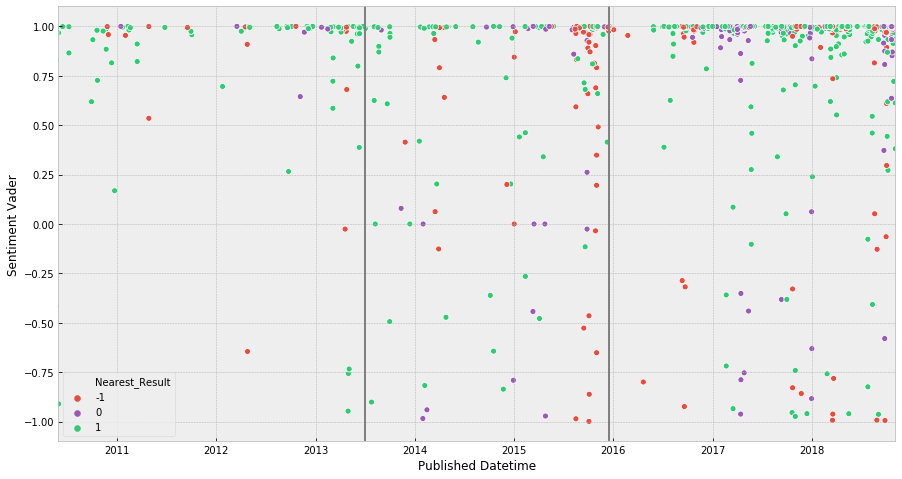

In [49]:
plt.figure(figsize=(15,8))
flatui = ["#e74c3c","#9b59b6","#2ecc71" ]
sns.set_palette(flatui)

#sns.scatterplot(x="Date", y="Num_Result", hue='Mourinho Team', data=results)
lm = sns.scatterplot(x='Published Datetime',y='Sentiment Vader',data=fin, hue='Nearest_Result', 
                legend='full',palette=flatui, alpha=1)

plt.axvline(x=datetime.strptime('Jun 30 2013', '%b %d %Y'), color='gray', linestyle='-')

plt.axvline(x=datetime.strptime('Dec 15 2015', '%b %d %Y'), color='gray', linestyle='-')
lm.set(xlim=(datetime.strptime('May 30 2010', '%b %d %Y'), fin['Published Datetime'].max()));

# Plot Top 2 Topics With Team Results

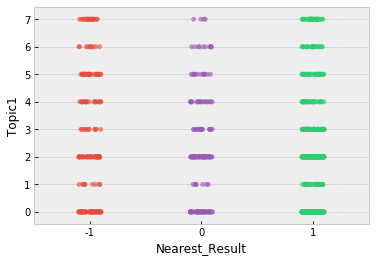

In [50]:
sns.stripplot(x='Nearest_Result',y='Topic1', jitter=True,data=fin,alpha=0.6,palette=flatui);

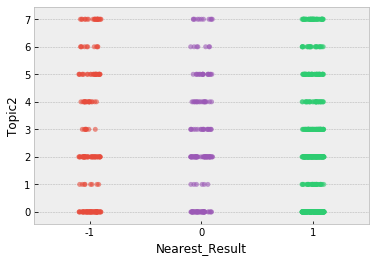

In [51]:
sns.stripplot(x='Nearest_Result',y='Topic2', jitter=True,data=fin,alpha=0.6,palette=flatui);

## Break press conferences by team and plot topics

In [52]:
datetime_object = datetime.strptime('Jan 1 2016', '%b %d %Y')

fin['Team'] = fin['Published Datetime'].apply(lambda x: 'Chelsea' if x < datetime.strptime('Sep 20 2007', '%b %d %Y')
                                            else 'Inter' if x < datetime.strptime('May 30 2010', '%b %d %Y')
                                            else 'Real Madrid' if x < datetime.strptime('Jun 30 2013', '%b %d %Y')
                                            else 'Chelsea' if x < datetime.strptime('Dec 15 2015', '%b %d %Y')
                                      else "Man United")

In [53]:
manu_interviews = fin.loc[fin['Team']=='Man United']
chelsea_interviews = fin.loc[fin['Team']=='Chelsea']
inter_interviews = fin.loc[fin['Team']=='Inter']
rm_interviews = fin.loc[fin['Team']=='Real Madrid']

In [54]:
def get_topics(df):
    tfidf = TfidfVectorizer(tokenizer=custom_tokenizer,max_df=0.25, min_df=3)
    word_freq =  tfidf.fit_transform(df['Caption'])
    model = NMF(n_components=5)
    doc_topics = model.fit_transform(word_freq)
    tfidf_feature_names = tfidf.get_feature_names()
    print_top_words(model, tfidf_feature_names, 10)
    topid=[]
    for doc in doc_topics:
        topid.append(np.argmax(doc))
    print("Topics: "+str(12)+" "+str(Counter(topid)))
    return

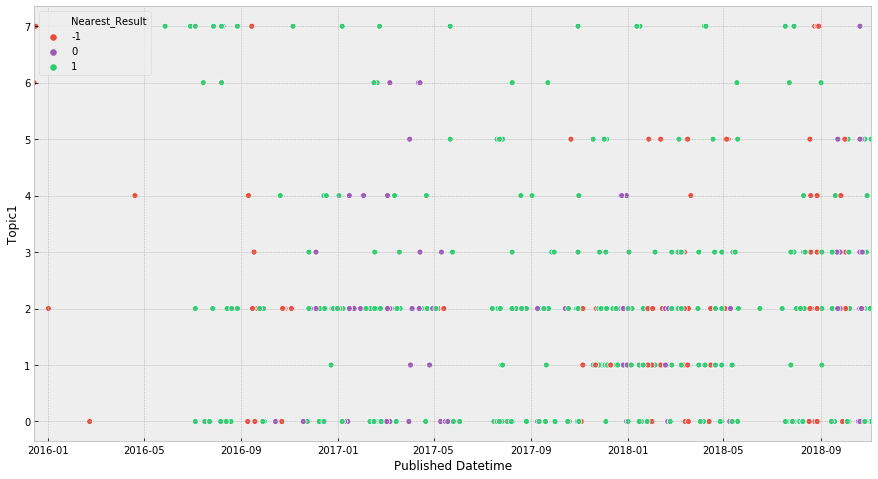

In [55]:
plt.figure(figsize=(15,8))

#sns.scatterplot(x="Date", y="Num_Result", hue='Mourinho Team', data=results)
lm_manu = sns.scatterplot(x='Published Datetime',y='Topic1',data=manu_interviews, hue='Nearest_Result', 
                legend='full',palette=flatui, alpha=1)
lm_manu.set(xlim=(manu_interviews['Published Datetime'].min(), manu_interviews['Published Datetime'].max()));

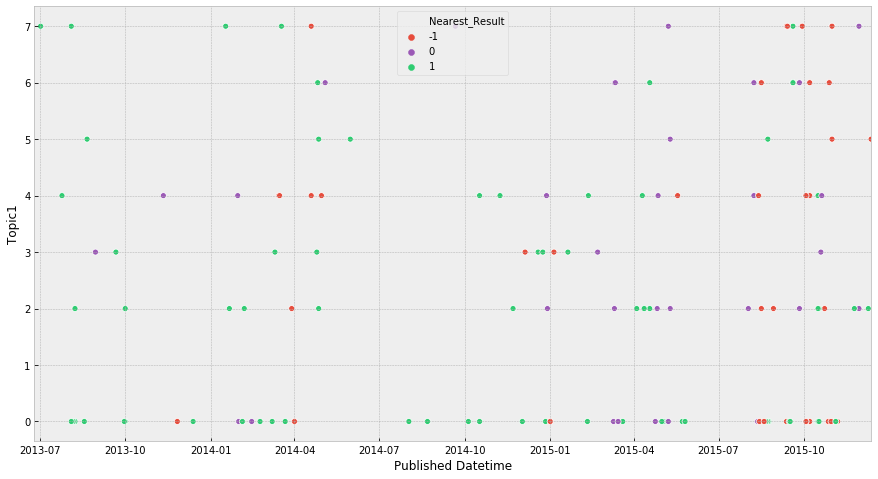

In [56]:
plt.figure(figsize=(15,8))
palette = sns.color_palette("husl",3)
#sns.scatterplot(x="Date", y="Num_Result", hue='Mourinho Team', data=results)
lm_chel = sns.scatterplot(x='Published Datetime',y='Topic1',data=chelsea_interviews, hue='Nearest_Result', 
                legend='full',palette=flatui, alpha=1)
lm_chel.set(xlim=(rm_interviews['Published Datetime'].max(), chelsea_interviews['Published Datetime'].max()));

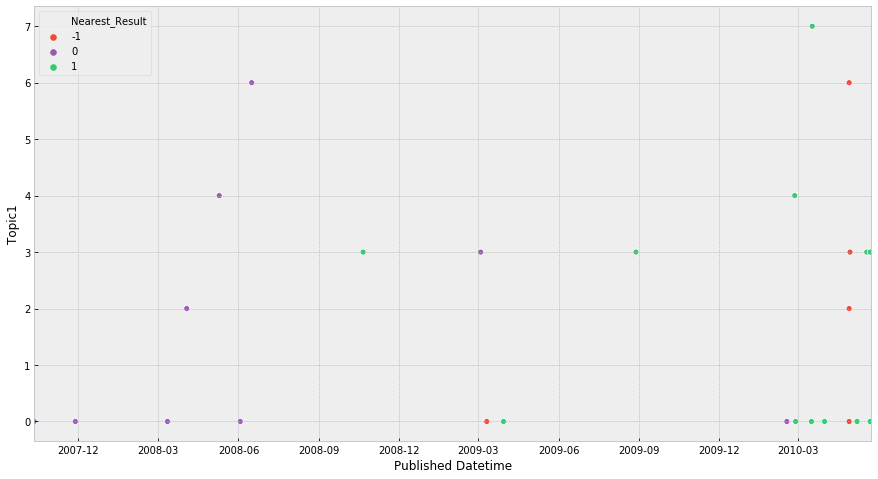

In [57]:
plt.figure(figsize=(15,8))
palette = sns.color_palette("husl",3)
#sns.scatterplot(x="Date", y="Num_Result", hue='Mourinho Team', data=results)
lm_inter = sns.scatterplot(x='Published Datetime',y='Topic1',data=inter_interviews, hue='Nearest_Result', 
                legend='full',palette=flatui, alpha=1)
lm_inter.set(xlim=(inter_interviews['Published Datetime'].min(), inter_interviews['Published Datetime'].max()));

(733922.0, 737001.0)


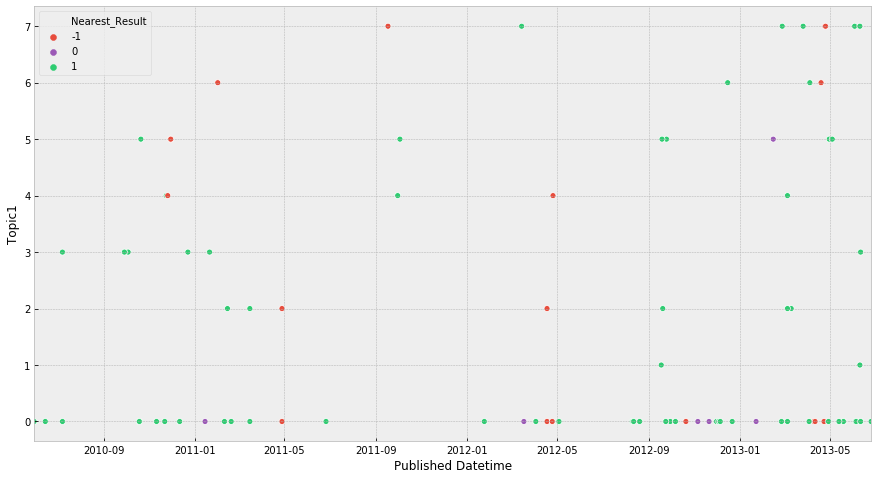

In [58]:
plt.figure(figsize=(15,8))
palette = sns.color_palette("husl",3)
#sns.scatterplot(x="Date", y="Num_Result", hue='Mourinho Team', data=results)
lm_rm = sns.scatterplot(x='Published Datetime',y='Topic1',data=rm_interviews, hue='Nearest_Result', 
                legend='full',palette=flatui, alpha=1)
print(lm.get_xlim())

lm_rm.set(xlim=(rm_interviews['Published Datetime'].min(), rm_interviews['Published Datetime'].max()));

## Export Main Df

In [59]:
#fin=fin.drop(['Description'],axis='columns')

In [60]:
fin.to_csv('Data/mou.csv',index=False)

## Separate into Year 1,2,3

Combine all of the press conferences from his first year at clubs, second year at clubs, and third year at clubs to test the theory that he gets more negative in his third year.

In [61]:
year1_rm = fin.loc[(fin['Published Datetime']>datetime.strptime('May 30 2010', '%b %d %Y'))&(fin['Published Datetime']<datetime.strptime('Jun 30 2011', '%b %d %Y'))]
year1_chel = fin.loc[(fin['Published Datetime']>datetime.strptime('Jul 30 2013', '%b %d %Y'))&(fin['Published Datetime']<datetime.strptime('Jun 30 2014', '%b %d %Y'))]
year1_manu = fin.loc[(fin['Published Datetime']>datetime.strptime('May 27 2016', '%b %d %Y'))&(fin['Published Datetime']<datetime.strptime('Jun 30 2017', '%b %d %Y'))]
year1 = pd.concat([year1_rm,year1_chel,year1_manu])

In [62]:
year2_rm = fin.loc[(fin['Published Datetime']>datetime.strptime('Jul 1 2011', '%b %d %Y'))&(fin['Published Datetime']<datetime.strptime('Jun 30 2012', '%b %d %Y'))]
year2_chel = fin.loc[(fin['Published Datetime']>datetime.strptime('Jul 1 2014', '%b %d %Y'))&(fin['Published Datetime']<datetime.strptime('Jun 30 2015', '%b %d %Y'))]
year2_manu = fin.loc[(fin['Published Datetime']>datetime.strptime('Jul 1 2017', '%b %d %Y'))&(fin['Published Datetime']<datetime.strptime('Jun 30 2018', '%b %d %Y'))]
year2 = pd.concat([year2_rm,year2_chel,year2_manu])


In [63]:
year3_rm = fin.loc[(fin['Published Datetime']>datetime.strptime('Jul 1 2012', '%b %d %Y'))&(fin['Published Datetime']<datetime.strptime('Jun 30 2013', '%b %d %Y'))]
year3_chel = fin.loc[(fin['Published Datetime']>datetime.strptime('Jul 1 2015', '%b %d %Y'))&(fin['Published Datetime']<datetime.strptime('Dec 17 2015', '%b %d %Y'))]
year3_manu = fin.loc[(fin['Published Datetime']>datetime.strptime('May 27 2018', '%b %d %Y'))&(fin['Published Datetime']<datetime.strptime('Jun 30 2019', '%b %d %Y'))]
year3 = pd.concat([year3_rm,year3_chel,year3_manu])

In [64]:
year1['Published Datetime']=year1['Published Datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
year1['Published Datetime']=year1['Published Datetime'].apply(lambda x:x[5:])
year1['Published Datetime']=year1['Published Datetime'].apply(lambda x:x+'-2010' if int(x[:2])>6
                                                             else x+'-2011')
year1['Published Datetime'] = pd.to_datetime(year1['Published Datetime'],format='%m-%d-%Y')

In [65]:
year2['Published Datetime']=year2['Published Datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
year2['Published Datetime']=year2['Published Datetime'].apply(lambda x:x[5:])
year2['Published Datetime']=year2['Published Datetime'].apply(lambda x:x+'-2010' if int(x[:2])>6
                                                             else x+'-2011')
year2['Published Datetime'] = pd.to_datetime(year2['Published Datetime'],format='%m-%d-%Y')

In [66]:
year3['Published Datetime']=year3['Published Datetime'].apply(lambda x: x.strftime('%Y-%m-%d'))
year3['Published Datetime']=year3['Published Datetime'].apply(lambda x:x[5:])
year3['Published Datetime']=year3['Published Datetime'].apply(lambda x:x+'-2010' if int(x[:2])>6
                                                             else x+'-2011')
year3['Published Datetime'] = pd.to_datetime(year3['Published Datetime'],format='%m-%d-%Y')

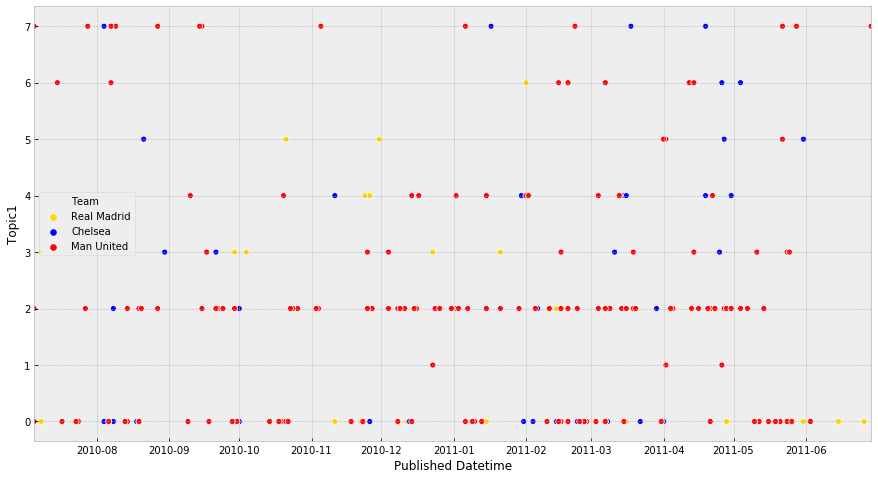

In [67]:
plt.figure(figsize=(15,8))
teams = ["gold","blue","red"]
sns.set_palette(teams)
#sns.scatterplot(x="Date", y="Num_Result", hue='Mourinho Team', data=results)
lm_y1 = sns.scatterplot(x='Published Datetime',y='Topic1',data=year1, hue='Team', 
                legend='full',palette=teams, alpha=1)
lm_y1.set(xlim=(year1['Published Datetime'].min(), year1['Published Datetime'].max()));

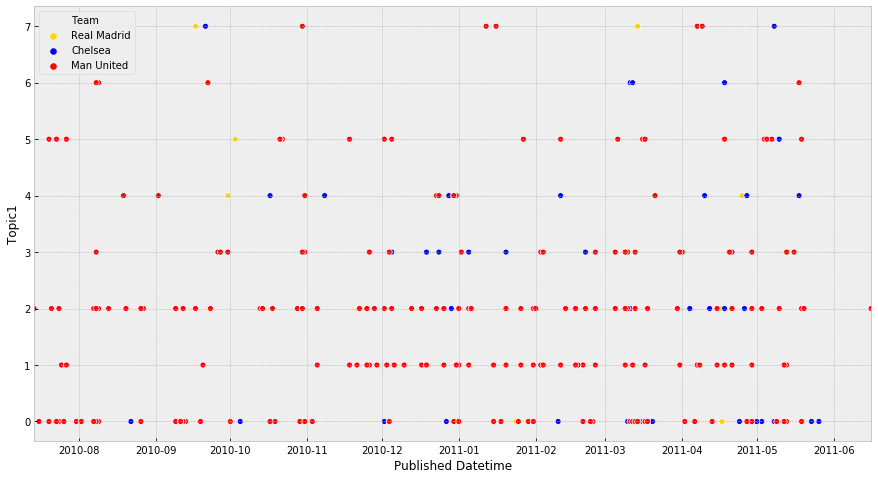

In [68]:
plt.figure(figsize=(15,8))
teams = ["gold","blue","red"]
sns.set_palette(teams)
#sns.scatterplot(x="Date", y="Num_Result", hue='Mourinho Team', data=results)
lm_y2 = sns.scatterplot(x='Published Datetime',y='Topic1',data=year2, hue='Team', 
                legend='full',palette=teams, alpha=1)
lm_y2.set(xlim=(year2['Published Datetime'].min(), year2['Published Datetime'].max()));

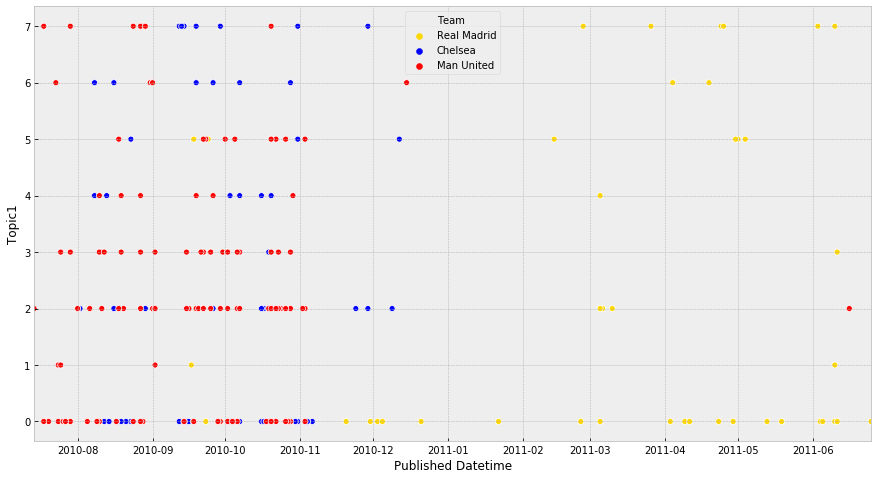

In [69]:
plt.figure(figsize=(15,8))
teams = ["gold","blue","red"]
sns.set_palette(teams)
#sns.scatterplot(x="Date", y="Num_Result", hue='Mourinho Team', data=results)
lm_y3 = sns.scatterplot(x='Published Datetime',y='Topic1',data=year3, hue='Team', 
                legend='full',palette=teams, alpha=1)
lm_y3.set(xlim=(year2['Published Datetime'].min(), year3['Published Datetime'].max()));

In [70]:
topics=['Generic Soccer and Player Rumors', 'Zen','Park the Bus'
                         ,'Generic Words','Complain about the Referee',"I'm sad we lost"
                         ,'Beautiful Spirit Defense','Fans/Deserve']

In [71]:
scores_year1=[]
scores_year2=[]
scores_year3=[]
for top in topics:
    scores_year1.append(year1[top].sum())
    scores_year2.append(year2[top].sum())
    scores_year3.append(year3[top].sum())

In [72]:
print(sum(scores_year1))
print(sum(scores_year2))
print(sum(scores_year3))

50.03170400475777
72.76670276098075
65.42336433015691


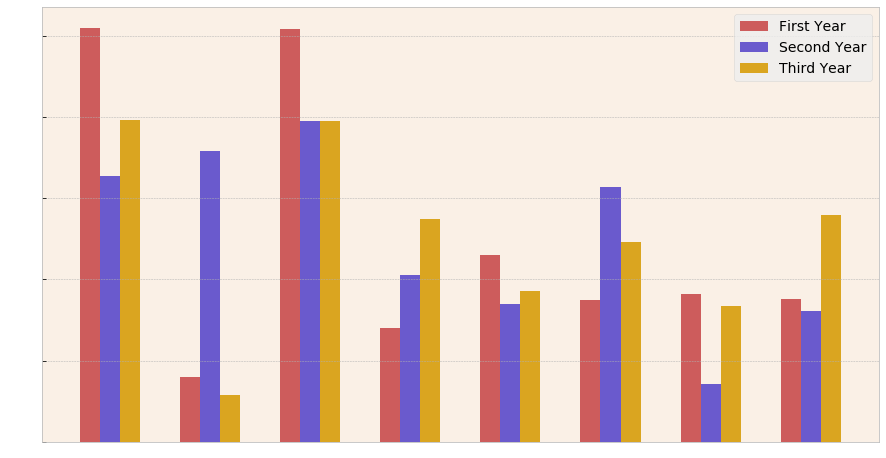

In [73]:
plt.figure(figsize=(15,8))
x=np.array(range(8))
ax = plt.subplot(111)
ax.bar(x-0.2, scores_year1/sum(scores_year1),width=0.2,color='indianred',align='center')
ax.bar(x, scores_year2/sum(scores_year2),width=0.2,color='slateblue',align='center')
ax.bar(x+0.2, scores_year3/sum(scores_year3),width=0.2,color='goldenrod',align='center')
ax.set_facecolor('linen');
ax.set_yticklabels(['0.00','0.05','0.10','0.15','0.20','0.25'],fontsize=16,color='w',fontname='Arial');
ax.legend(['First Year','Second Year','Third Year'],fontsize=14);
ax.get_xaxis().set_visible(False)

## Stacked Bars

Make a stacked bar chart to show how the distribution of topics has changed over Jose's career

In [74]:
stack = fin[['Published Datetime','Generic Soccer and Player Rumors', 'Zen',
       'Park the Bus', 'Generic Words', 'Complain about the Referee',
       "I'm sad we lost", 'Beautiful Spirit Defense', 'Fans/Deserve']]

In [75]:
stack=stack.sort_values(by=['Published Datetime'])

In [76]:
stack['MonthYear']=stack['Published Datetime'].apply(lambda x: str(x.year) +" "+ str(x.month))

In [77]:
stack.head()

,Published Datetime,Generic Soccer and Player Rumors,Zen,Park the Bus,Generic Words,Complain about the Referee,I'm sad we lost,Beautiful Spirit Defense,Fans/Deserve,MonthYear
196,2006-08-24,0.047486,0.000000,0.051249,0.035442,0.046632,0.014883,0.002143,0.000000,2006 8
857,2006-10-16,0.063248,0.000000,0.038314,0.060236,0.019356,0.000000,0.097710,0.072325,2006 10
540,2006-10-24,0.073212,0.000633,0.000000,0.002474,0.003882,0.004291,0.000000,0.000000,2006 10
332,2007-10-12,0.044497,0.000000,0.000000,0.000000,0.025005,0.000000,0.000000,0.000000,2007 10
94,2007-11-28,0.053266,0.000000,0.000000,0.005331,0.000000,0.000000,0.017512,0.000000,2007 11


In [78]:
monthbymonth = stack.groupby(['MonthYear']).sum()

In [79]:
monthbymonth=monthbymonth.sort_values(by=['MonthYear'])

In [80]:
monthbymonth.head()

,Generic Soccer and Player Rumors,Zen,Park the Bus,Generic Words,Complain about the Referee,I'm sad we lost,Beautiful Spirit Defense,Fans/Deserve
MonthYear,,,,,,,,
2006 10,0.136460,0.000633,0.038314,0.062710,0.023238,0.004291,0.097710,0.072325
2006 8,0.047486,0.000000,0.051249,0.035442,0.046632,0.014883,0.002143,0.000000
2007 10,0.044497,0.000000,0.000000,0.000000,0.025005,0.000000,0.000000,0.000000
2007 11,0.053266,0.000000,0.000000,0.005331,0.000000,0.000000,0.017512,0.000000
2008 10,0.015035,0.000000,0.000000,0.029470,0.000000,0.000000,0.009180,0.000000


In [81]:
monthbymonth['sum']=monthbymonth.sum(axis=1)

In [82]:
grouped_months = monthbymonth[['Generic Soccer and Player Rumors','Zen','Park the Bus','Generic Words','Complain about the Referee',"I'm sad we lost",'Beautiful Spirit Defense','Fans/Deserve']].div(monthbymonth['sum'], axis=0)

In [83]:
grouped_months['sum']=grouped_months.sum(axis=1)

In [84]:
grouped_months.head()

,Generic Soccer and Player Rumors,Zen,Park the Bus,Generic Words,Complain about the Referee,I'm sad we lost,Beautiful Spirit Defense,Fans/Deserve,sum
MonthYear,,,,,,,,,
2006 10,0.313211,0.001453,0.087940,0.143936,0.053337,0.009850,0.224269,0.166004,1.0
2006 8,0.240029,0.000000,0.259048,0.179151,0.235713,0.075229,0.010830,0.000000,1.0
2007 10,0.640227,0.000000,0.000000,0.000000,0.359773,0.000000,0.000000,0.000000,1.0
2007 11,0.699868,0.000000,0.000000,0.070038,0.000000,0.000000,0.230094,0.000000,1.0
2008 10,0.280064,0.000000,0.000000,0.548946,0.000000,0.000000,0.170991,0.000000,1.0


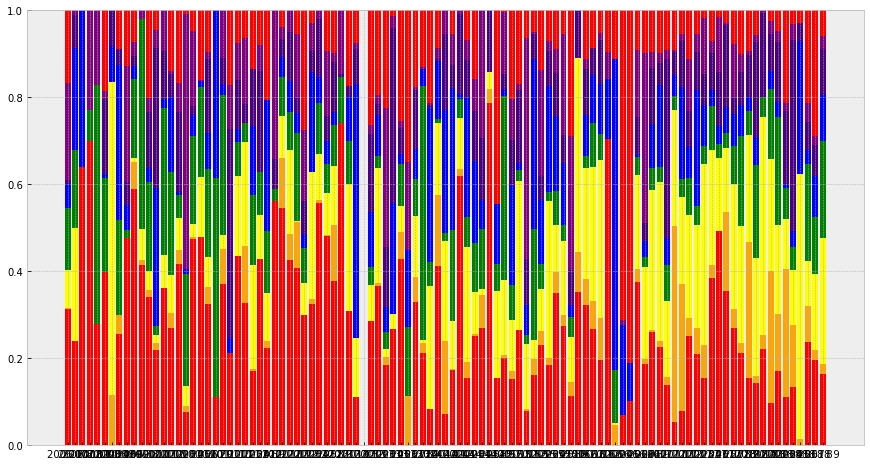

In [85]:
plt.figure(figsize=(15,8))
b1 = plt.bar(grouped_months.index,grouped_months['Generic Soccer and Player Rumors'],color='r')
b2 = plt.bar(grouped_months.index,grouped_months['Zen'],color='orange',bottom=grouped_months['Generic Soccer and Player Rumors'])
b3 = plt.bar(grouped_months.index,grouped_months['Park the Bus'],color='yellow',bottom=grouped_months['Zen']+grouped_months['Generic Soccer and Player Rumors'])
b4 = plt.bar(grouped_months.index,grouped_months['Generic Words'],color='green',bottom=grouped_months['Park the Bus']+grouped_months['Zen']+grouped_months['Generic Soccer and Player Rumors'])
b5 = plt.bar(grouped_months.index,grouped_months['Complain about the Referee'],color='blue',bottom=grouped_months['Generic Words']+grouped_months['Park the Bus']+grouped_months['Zen']+grouped_months['Generic Soccer and Player Rumors'])
b6 = plt.bar(grouped_months.index,grouped_months["I'm sad we lost"],color='indigo',bottom=grouped_months['Complain about the Referee']+grouped_months['Generic Words']+grouped_months['Park the Bus']+grouped_months['Zen']+grouped_months['Generic Soccer and Player Rumors'])
b7 = plt.bar(grouped_months.index,grouped_months['Beautiful Spirit Defense'],color='purple',bottom=grouped_months["I'm sad we lost"]+grouped_months['Complain about the Referee']+grouped_months['Generic Words']+grouped_months['Park the Bus']+grouped_months['Zen']+grouped_months['Generic Soccer and Player Rumors'])
b8 = plt.bar(grouped_months.index,grouped_months['Fans/Deserve'],color='r',bottom=grouped_months['Beautiful Spirit Defense']+grouped_months["I'm sad we lost"]+grouped_months['Complain about the Referee']+grouped_months['Generic Words']+grouped_months['Park the Bus']+grouped_months['Zen']+grouped_months['Generic Soccer and Player Rumors'])
